<a href="https://colab.research.google.com/github/KendallScott/Machine-Learning/blob/main/SVM%20and%20LR/Sunday/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contributors:
### Austin Webb 
### Tadd Backus
### Kendall Scott

--redacted code not present in project from Milan Patel

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from google.colab import files
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

In [4]:
files.upload()
# read the files into a dataframe
forest_cover_type = pd.read_csv('covtype.csv') 

# verify the dataframe loaded
print(forest_cover_type.shape)
forest_cover_type.head()


Saving covtype.csv to covtype (1).csv
(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# Data Preparation Part 1

In [5]:
# Data clean-up
# make list of continuous variables
continuous_variables = ['Elevation', 
                        'Aspect', 
                        'Slope', 
                        'Horizontal_Distance_To_Hydrology', 
                        'Vertical_Distance_To_Hydrology',
                        'Horizontal_Distance_To_Roadways',
                        'Hillshade_9am','Hillshade_Noon',
                        'Hillshade_3pm',
                        'Horizontal_Distance_To_Fire_Points']

# use list to make df
continuous_variables_df = forest_cover_type[continuous_variables]

# subset df to make binary categorical
# second number not inclusive
Wilderness_Area = forest_cover_type.iloc[:, 10:14]
Wilderness_Area['Wilderness_Area'] = Wilderness_Area.idxmax(axis = 1)

# subset df to make binary categorical
# second number not inclusive
Soil_Type = forest_cover_type.iloc[:, 14:54]
Soil_Type['Soil_Type'] = Soil_Type.idxmax(axis = 1)

# only keep the new column
Soil_Type = Soil_Type[['Soil_Type']]
Wilderness_Area = Wilderness_Area[['Wilderness_Area']]

# Add new columns to df
forest_cover_type['Soil_Type'] = Soil_Type
forest_cover_type['Wilderness_Area'] = Wilderness_Area

# delete first few characters in column so we only have number
forest_cover_type['Soil_Type'] = forest_cover_type['Soil_Type'].str[9:]
forest_cover_type['Wilderness_Area'] = forest_cover_type['Wilderness_Area'].str[15:]


# delete superfluous columns now that new columns are added
forest_cover_type.drop(forest_cover_type.iloc[:, 10:54], 
                       axis = 1, 
                       inplace = True)



In [6]:
# Convert to category data type
forest_cover_type['Cover_Type'] = forest_cover_type['Cover_Type'].astype('category')
forest_cover_type['Soil_Type'] = forest_cover_type['Soil_Type'].astype('category')
forest_cover_type['Wilderness_Area'] = forest_cover_type['Wilderness_Area'].astype('category')

In [7]:
# Check the data types
forest_cover_type.dtypes

Elevation                                int64
Aspect                                   int64
Slope                                    int64
Horizontal_Distance_To_Hydrology         int64
Vertical_Distance_To_Hydrology           int64
Horizontal_Distance_To_Roadways          int64
Hillshade_9am                            int64
Hillshade_Noon                           int64
Hillshade_3pm                            int64
Horizontal_Distance_To_Fire_Points       int64
Cover_Type                            category
Soil_Type                             category
Wilderness_Area                       category
dtype: object

In [8]:
forest_cover_type

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
0,2596,51,3,258,0,510,221,232,148,6279,5,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,5,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,2,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,2,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,5,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,3,2,3
581008,2391,152,19,67,12,95,240,237,119,845,3,2,3
581009,2386,159,17,60,7,90,236,241,130,854,3,2,3
581010,2384,170,15,60,5,90,230,245,143,864,3,2,3


In [ ]:
forest_cover_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   Elevation                           581012 non-null  int64   
 1   Aspect                              581012 non-null  int64   
 2   Slope                               581012 non-null  int64   
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64   
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64   
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64   
 6   Hillshade_9am                       581012 non-null  int64   
 7   Hillshade_Noon                      581012 non-null  int64   
 8   Hillshade_3pm                       581012 non-null  int64   
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64   
 10  Cover_Type                          581012 non-null  category
 11  Soil_Type    

## Data Meaning 

Attributes:	

- 10 quantitative variables
  - Elevation - Elevation in meters
  - Aspect - Aspect in degrees azimuth
  - Slope - Slope in degrees
  - Horizontal Distance to Hydrology - Horz Dist to nearest surface water features (meters)
  - Vertical Distance to Hydrology - Vert Dist to nearest surface water features (meters)
  - Horizontal Distance to Roadways - Horz Dist to nearest roadway (meters)
  - Hill shade 9 am (0 to 255 index) - Hillshade index at 9am, summer solstice
  - Hill shade noon (0 to 255 index) - Hillshade index at noon, summer solstice
  - Hill shade 3 pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
  - Horizontal distance to fire points - Horz Dist to nearest wildfire ignition points (meters)


- 3 Categorical variables
	- Wilderness area
  - 1: Neota
  - 2: Rawah
  - 3: Comanche Peak
  - 4: Cache la Poudre
	- Cover Type
  - 1: Spruce/Fir
  - 2: Lodgepole Pine
  - 3: Ponderosa Pine
  - 4: Cottonwood/Willow
  - 5: Aspen
  - 6: Douglas-fir
  - 7: Krummholz
	- Soil Type
		- 1: Cathedral family - Rock outcrop complex, extremely stony.
		- 2: Vanet - Ratake families complex, very stony.
		- 3: Haploborolis - Rock outcrop complex, rubbly.
		- 4: Ratake family - Rock outcrop complex, rubbly.
		- 5: Vanet family - Rock outcrop complex complex, rubbly.
		- 6: Vanet - Wetmore families - Rock outcrop complex, stony.
		- 7: Gothic family.
		- 8: Supervisor - Limber families complex.
		- 9: Troutville family, very stony.
		- 10: Bullwark - Catamount families - Rock outcrop complex, rubbly.
		- 11: Bullwark - Catamount families - Rock land complex, rubbly.
		- 12: Legault family - Rock land complex, stony.
		- 13: Catamount family - Rock land - Bullwark family complex, rubbly.
		- 14: Pachic Argiborolis - Aquolis complex.
		- 15: unspecified in the USFS Soil and ELU Survey.
		- 16: Cryaquolis - Cryoborolis complex.
		- 17: Gateview family - Cryaquolis complex.
		- 18: Rogert family, very stony.
		- 19: Typic Cryaquolis - Borohemists complex.
		- 20: Typic Cryaquepts - Typic Cryaquolls complex.
		- 21: Typic Cryaquolls - Leighcan family, till substratum complex.
		- 22: Leighcan family, till substratum, extremely bouldery.
		- 23: Leighcan family, till substratum - Typic Cryaquolls complex.
		- 24: Leighcan family, extremely stony.
		- 25: Leighcan family, warm, extremely stony.
		- 26: Granile - Catamount families complex, very stony.
		- 27: Leighcan family, warm - Rock outcrop complex, extremely stony.
		- 28: Leighcan family - Rock outcrop complex, extremely stony.
		- 29: Como - Legault families complex, extremely stony.
		- 30: Como family - Rock land - Legault family complex, extremely stony.
		- 31: Leighcan - Catamount families complex, extremely stony.
		- 32: Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
		- 33: Leighcan - Catamount families - Rock outcrop complex, extremely stony.
		- 34: Cryorthents - Rock land complex, extremely stony.
		- 35: Cryumbrepts - Rock outcrop - Cryaquepts complex.
		- 36: Bross family - Rock land - Cryumbrepts complex, extremely stony.
		- 37: Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
		- 38: Leighcan - Moran families - Cryaquolls complex, extremely stony.
		- 39: Moran family - Cryorthents - Leighcan family complex, extremely stony.
		- 40: Moran family - Cryorthents - Rock land complex, extremely stony.	
	

---
# Data Preparation Part 2

We brought our original data down from 55 columns down to 13. This will, not only make it easier to view and understand the data, but also allow the machine to run the models we will create. 

We converted the following features into categorical features: Wilderness Area, Cover Type, Soil Type. The Soil Type feature was initially was spread out in binary columns for each type (40 of them). Wilderness Area was also like this, but just with less columns. Once combined into one column, the binary features were converted into categorical. 

The remaining 10 features are integer data types. The measurements used for these 10 features have no decimal point, so no need to convert to float. They have remained as an integer.

Using multiple continuous variables will help us create regression models, whereas having a few categorical features will allow for classification models. 



---
# Modeling and Evaluation 1

We will look at a variety of different metrics. We will look at accuracy first. We do this to get a general undersanding of the data models. We will look at other evaluation metrics due to accuracy being a good metric when the distributions are equal. Accuracy can be misleading becasue of the class distribution.

We will also measure the precision and recall for the models. These metrics  are good evaluation tools due to them taking into account both true positives and false positives/negatives. This allows for them being good despite the imbalnaced data. These two metrics are good indeicators but should still be looked at with caution. 

We will also look at the F1 score becasue of the caution that we place in the aforementioned metrics. F1 score is useful in imbalanced datasets because it takes into account both true positives and false positives/negatives. F1 score provides a trade-off between precision and recall; it is the harmonic mean of precision and recall.  

---
# Modeling and Evaluation 2	


We wanted to look at various splitting methods to measure various metrics for each one. We will start with test/train split.

We will use test/train due to its simpliity and ease of implementation. However, we also have slight cause for concern for thsi exact reason. It is a quick model splitting method.

We also will take a look at Cross Validation. This provides a more reliable estimate for model performance by averaging across folds. This is computationally expensive for large datasets like the one we have.

Finally, we will take a look at stratified cross validation. This will probably be the best one for our particular dataset because it ensures that the class proportions are maintained in each fold. This is good for imbalanced datasets like our own. 

We decided to do a comparison of numerous methods of validation:

- Test/Train 80/20 split
- 10 fold cross validation
- Stratified 10-fold cross-validation 

This allowed us to do a comparison across models, and see if there are any models which had differences in
- accuracy
- precision
- recall 
- f-1 score

When utilizing a different validation method.

---
# Modeling and Evaluation 3

### Random Forest

#### Test/Train Split

In [9]:
# Make target variable and data variable
y = forest_cover_type[['Cover_Type']]
X = forest_cover_type.loc[:, forest_cover_type.columns != 'Cover_Type']

In [10]:
# Takes about 2 min

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Create a random forest model
rfc = RandomForestClassifier(n_estimators = 100)

# Train the model on the training data
rfc.fit(X_train, y_train)

# Predict on the testing data
y_pred_rfc = rfc.predict(X_test)

# Calculate the accuracy of model
rfc_accuracy = accuracy_score(y_test, y_pred_rfc)

print('Accuracy:', rfc_accuracy) # 0.9625482990972695


Accuracy: 0.962832284880769


In [ ]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96     42557
           2       0.96      0.98      0.97     56500
           3       0.95      0.97      0.96      7121
           4       0.93      0.86      0.89       526
           5       0.94      0.81      0.87      1995
           6       0.95      0.92      0.93      3489
           7       0.98      0.96      0.97      4015

    accuracy                           0.96    116203
   macro avg       0.95      0.92      0.94    116203
weighted avg       0.96      0.96      0.96    116203



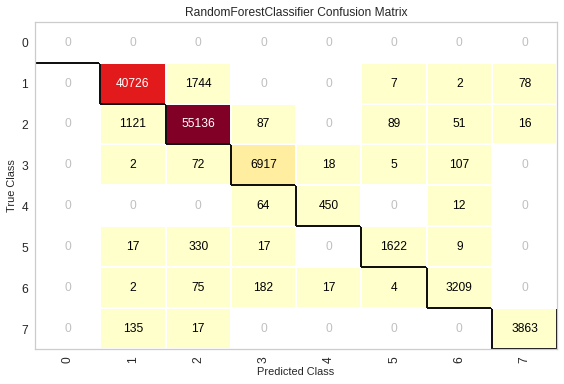

In [ ]:
# Adapted from https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(rfc, classes=[0, 1, 2, 3, 4, 5, 6, 7])

# Fit the model. 
cm.fit(X_train, y_train)

# Score runs predict() on the data and creates the confusion_matrix
cm.score(X_test, y_test)

cm.show();

#### Cross Validation

In [11]:
# takes about 8 min

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth = 30)

cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_idx, test_idx in cv.split(X, y):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rfc.fit(X_train, y_train)

    # Predict 
    y_pred_rfc = rfc.predict(X_test)

    # Calculate the accuracy, precision, recall and F1-score
    rfc_accuracy = accuracy_score(y_test, y_pred_rfc)
    rfc_precision = precision_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_recall = recall_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_f1 = f1_score(y_test, y_pred_rfc, average = 'weighted')
    y_scores_rfc = rfc.predict_proba(X_test)


    # add to the lists
    accuracies.append(rfc_accuracy)
    precisions.append(rfc_precision)
    recalls.append(rfc_recall)
    f1_scores.append(rfc_f1)

    print('Accuracy:', rfc_accuracy)
    print('Precision:', rfc_precision)
    print('Recall:', rfc_recall)
    print('F1-score:', rfc_f1)
    print('\n')

# Print the mean 
print('\n')
print('Mean Accuracy:', sum(accuracies) / len(accuracies))
print('Mean Precision:', sum(precisions) / len(precisions))
print('Mean Recall:', sum(recalls) / len(recalls))
print('Mean F1-score:', sum(f1_scores) / len(f1_scores))

Accuracy: 0.964200888093353
Precision: 0.9642064659030913
Recall: 0.964200888093353
F1-score: 0.9640925880396102


Accuracy: 0.9649065436645898
Precision: 0.9649205273231032
Recall: 0.9649065436645898
F1-score: 0.9647406658337715


Accuracy: 0.9650264195108518
Precision: 0.9650093804397739
Recall: 0.9650264195108518
F1-score: 0.9649126566218751


Accuracy: 0.9658353556737406
Precision: 0.9658349159599895
Recall: 0.9658353556737406
F1-score: 0.9657195970568467


Accuracy: 0.9644412316483365
Precision: 0.9644388248160484
Recall: 0.9644412316483365
F1-score: 0.9643297253667936


Accuracy: 0.9663000636822086
Precision: 0.96633218688998
Recall: 0.9663000636822086
F1-score: 0.9661650111843947


Accuracy: 0.9649231510645255
Precision: 0.9649312091820559
Recall: 0.9649231510645255
F1-score: 0.9647997553832504


Accuracy: 0.9657148758196933
Precision: 0.965722021942212
Recall: 0.9657148758196933
F1-score: 0.9655801508270097


Accuracy: 0.9669368857678869
Precision: 0.9669765133369553
Recall: 0.

In [12]:
# we looked at the AUCROC for Lodgepole Pine, due to it being the most popular cover type
y_test_alt=np.where(y_test['Cover_Type']== 1, 1, 0)
y_test_alt=pd.DataFrame(y_test_alt)
y_test_alt

y_scores_rfc=pd.DataFrame(y_scores_rfc)
y_test_alt=np.where(y_test['Cover_Type']== 1, 1, 0)
y_test_alt=pd.DataFrame(y_test_alt)

roc_auc_rf=roc_auc_score(y_test_alt, y_scores_rfc[0])
roc_auc_rf

0.9972800644023705

**Cross Validation**

Mean Accuracy: 0.6931698490077284

Mean Precision: 0.6893819463838445

Mean Recall: 0.6931698490077284

Mean F1-score: 0.6667046148754269

#### Stratified Cross Validation

# takes about 8 min

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth = 30)

# Create a stratified 10-fold cross-validation 
cv = StratifiedKFold(n_splits = 10, 
                     shuffle = True, 
                     random_state = 42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_idx, test_idx in cv.split(X, y):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    rfc.fit(X_train, y_train)

    # Predict 
    y_pred_rfc = rfc.predict(X_test)

    # Calculate the accuracy, precision, recall and F1-score
    rfc_accuracy = accuracy_score(y_test, y_pred_rfc)
    rfc_precision = precision_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_recall = recall_score(y_test, y_pred_rfc, average = 'weighted')
    rfc_f1 = f1_score(y_test, y_pred_rfc, average = 'weighted')

    # Append to the list
    accuracies.append(rfc_accuracy)
    precisions.append(rfc_precision)
    recalls.append(rfc_recall)
    f1_scores.append(rfc_f1)

# Print the scores
    print('Accuracy:', rfc_accuracy)
    print('Precision:', rfc_precision)
    print('Recall:', rfc_recall)
    print('F1-score:', rfc_f1)
    print('\n')

# Print the mean scores
print('\n')
print('Mean accuracy:', sum(accuracies) / len(accuracies))
print('Mean precision:', sum(precisions) / len(precisions))
print('Mean recall:', sum(recalls) / len(recalls))
print('Mean F1-score:', sum(f1_scores) / len(f1_scores))

**Stratified Cross Validation**

Mean accuracy: 0.6929839679964245

Mean precision: 0.6918305764108446

Mean recall: 0.6929839679964245

Mean F1-score: 0.6664447426103081

### KNN

#### Test/Train Split

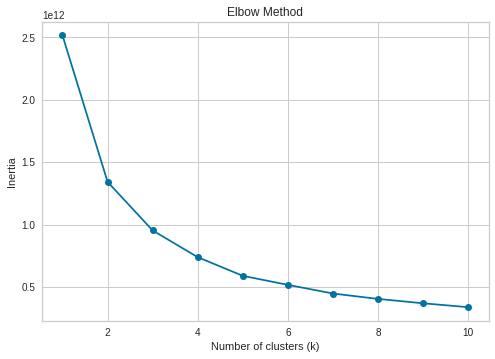

In [ ]:
# Takes 2.5 min

# Try different values of k to find the elbow point
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker = 'o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

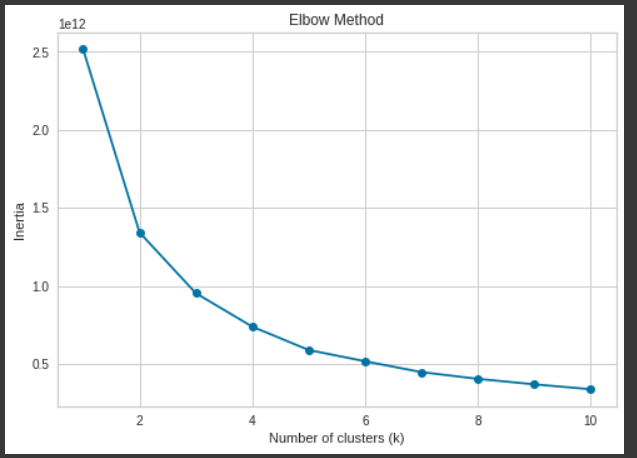

In [ ]:
from pandas.core.common import random_state
# Create a KNN classifier with k = 6
knn = KNeighborsClassifier(n_neighbors = 6)

# Train the model
knn.fit(X_train, y_train)

# Predict 
y_pred_knn = knn.predict(X_test)

# Calculate the metrics of the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn, average = 'weighted')
knn_recall = recall_score(y_test, y_pred_knn, average = 'weighted')
knn_f1 = f1_score(y_test, y_pred_knn, average = 'weighted')
y_scores_knn = knn.predict_proba(X_test)

# Print metrucs
print('\n')
print('Accuracy:', knn_accuracy) 
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('F1-score:', knn_f1)



Accuracy: 0.9657581990137948
Precision: 0.9659199715274907
Recall: 0.9657581990137948
F1-score: 0.9656226688940259


Accuracy: 0.9685547580936645

Precision: 0.9686905225021298

Recall: 0.9685547580936645

F1-score: 0.9684121945258358

In [ ]:
# print the metrics for each individual class
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97     21184
           2       0.98      0.97      0.97     28330
           3       0.96      0.97      0.97      3575
           4       0.93      0.79      0.85       275
           5       0.97      0.83      0.89       949
           6       0.95      0.92      0.93      1737
           7       0.99      0.95      0.97      2051

    accuracy                           0.97     58101
   macro avg       0.96      0.91      0.94     58101
weighted avg       0.97      0.97      0.97     58101



#### Cross Validation

In [13]:
# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors = 6)

# Evaluate the model using 10-fold cross validation
scores = cross_val_score(knn, 
                         X, 
                         y, 
                         cv = 10)


# Print the accuracy of each fold and the mean accuracy
print('\n')
print('Accuracy of each fold:', scores)
print('\n')
print('Mean accuracy:', scores.mean()) # Mean accuracy: 0.5362315601229429




Accuracy of each fold: [0.60906681 0.49218616 0.59344934 0.55694394 0.4901981  0.52844185
 0.53351922 0.50188465 0.4732965  0.58332903]


Mean accuracy: 0.5362315601229429


Mean accuracy: 0.5362315601229429

#### Stratified Cross Validation 

In [ ]:
# Use stratified 10 fold cross validation to evaluate the model
cv = StratifiedKFold(n_splits = 10)
scores = cross_val_score(knn, 
                         X, 
                         y, 
                         cv = cv)

# Print the accuracy of each fold and the mean accuracy
print('\n')
print('Accuracy of each fold:', scores)
print('\n')
print('Mean accuracy:', scores.mean()) # 0.5362315601229429



Accuracy of each fold: [0.60906681 0.49218616 0.59344934 0.55694394 0.4901981  0.52844185
 0.53351922 0.50188465 0.4732965  0.58332903]


Mean accuracy: 0.5362315601229429


Mean accuracy: 0.5362315601229429

### Logistic Regression

#### Test/Train Split

In [ ]:
forest_cover_hot_coded_category = pd.read_csv('covtype.csv')
# Renaming wilderness areas
forest_cover_hot_coded_category.rename(columns={'Wilderness_Area1':'Rawah','Wilderness_Area2':'Neota','Wilderness_Area3':'Comanche Peak','Wilderness_Area4':'Cache la Poudre'},inplace=True)


#reference https://www.analyticsvidhya.com/blog/2021/05/how-to-perform-one-hot-encoding-for-multi-categorical-variables/
# setting columns we use
new_df = pd.read_csv('covtype.csv',usecols=['Cover_Type']) 
new_df.head()
new_df.to_numpy()
onehot = OneHotEncoder()
onehot.fit_transform(new_df.Cover_Type.values.reshape(-1, 1)).toarray()
new_df=onehot.fit_transform(new_df.Cover_Type.values.reshape(-1, 1)).toarray()
new_df = pd.DataFrame(new_df)

new_df = new_df.rename(columns={0: 'Spruce_Fir', 
                                1: 'Lodgepole_Pine',
                                2: 'Ponderosa_Pine',
                                3: 'Cottonwood_Willow',
                                4: 'Aspen',
                                5: 'Douglas_fir',
                                6: 'Krummholz'
                                })

forest_cover_hot_coded_category = pd.concat([forest_cover_hot_coded_category.reset_index(drop=True), new_df], axis=1)

forest_cover_hot_coded_category = forest_cover_hot_coded_category.select_dtypes(['number']) 
# forest_cover_hot_coded_category.head()

In [ ]:
# Make target variable and data variable
ylog = forest_cover_hot_coded_category[['Cover_Type']]
Xlog = forest_cover_hot_coded_category.loc[:, forest_cover_hot_coded_category.columns != 'Cover_Type']


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xlog, 
                                                    ylog, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Create a logistic regression classifier
lr = LogisticRegression()

# Train the classifier on the training data
lr.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred_lr = lr.predict(y_test)

# Calculate the accuracy of the classifier
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print('\n')
print('Accuracy:', lr_accuracy) # 0.6239339776081513
print('\n')



Accuracy: 0.6239339776081513




In [ ]:
# print the metrics for each individual class
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           1       0.62      0.64      0.63     42557
           2       0.63      0.77      0.69     56500
           3       0.65      0.23      0.34      7121
           4       0.00      0.00      0.00       526
           5       0.00      0.00      0.00      1995
           6       0.06      0.00      0.00      3489
           7       0.05      0.00      0.00      4015

    accuracy                           0.62    116203
   macro avg       0.29      0.23      0.24    116203
weighted avg       0.58      0.62      0.59    116203



#### Cross Validation

In [ ]:
# Perform 10-fold cross-validation and calculate the mean accuracy
#takes # minutes to run
cv_scores = cross_val_score(lr, Xlog, ylog, cv = 10)
mean_accuracy = cv_scores.mean()

y_scores_log = lr.predict_proba(X_test)

y_pred_lr = lr.predict(X_test)

# Calculate the metrics of the model
log_accuracy = accuracy_score(y_test, y_pred_lr)
log_precision = precision_score(y_test, y_pred_lr, average = 'weighted')
log_recall = recall_score(y_test, y_pred_lr, average = 'weighted')
log_f1 = f1_score(y_test, y_pred_lr, average = 'weighted')

print('\n')
print('Cross-validation accuracy:', mean_accuracy) # 0.6009685968081737
print('\n')



Cross-validation accuracy: 0.601653620492486




Cross-validation accuracy: 0.6009685968081737


#### Stratified Cross Validation

In [ ]:
# Create a stratified 10-fold cross-validator
skf = StratifiedKFold(n_splits = 10)

# Perform cross-validation
cv_scores = cross_val_score(lr, X, y, cv = skf)

# Calculate the mean accuracy of the cross-validation scores
mean_accuracy = cv_scores.mean()

print('\n')
print('Cross-validation accuracy:', mean_accuracy)
print('\n')

Cross-validation accuracy: 0.6009685968081737


**Accuracy Scores for various splitting methods vs Classification models**

Splitting Method   | Random Forest | KNN    | Logistic
-------------------|---------------|--------|---------
Test/Train         | 0.9625        | 0.9658 | 0.6242
Cross Validation   | 0.9656        | 0.5362 | 0.6009
Stratified CV      | 0.9655        | 0.5362 | 0.6009

Because we saw a large difference in accuracy for different validation methods, we decided to narrow down our validation method for the regression models to 10 fold Cross Validation.



### Regression Models for Elevation

As we saw in our initial EDA, there is a clear relationship between Cover Type and Elevation, which we will analyze using regression models. There are also irregular patterns with Horizontal Distance to Fire Points and Elevation.

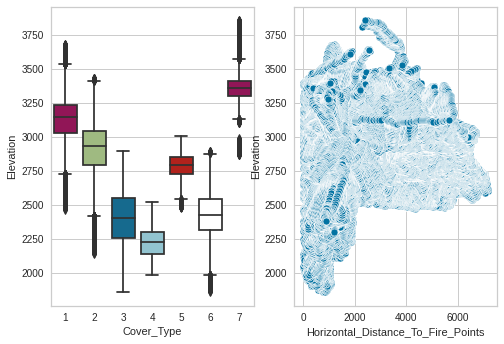

In [ ]:
#side by side plot
fig, ax =plt.subplots(1,2)

# box plots for elevation vs cover type
sns.boxplot(x = 'Cover_Type', y = 'Elevation', data = forest_cover_type, ax=ax[0], palette=["m", "g", "b", "c", "r", "w", "m"])

# scatter plots 
sns.scatterplot(x = 'Horizontal_Distance_To_Fire_Points', y = 'Elevation', data = forest_cover_type, ax=ax[1])

fig.show()

In [ ]:
# Make target variable and data variable
yreg = forest_cover_type[['Elevation']]
Xreg = forest_cover_type.loc[:, forest_cover_type.columns != 'Elevation']

Random Forest for Elevation

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create a random forest model
rf_reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators = 100)

In [ ]:
#about 30 minute run time
# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []
MSE = []
RMSE = []

for train_idx_reg, test_idx_reg in cv.split(Xreg, yreg):

    X_train_reg, X_test_reg = Xreg.iloc[train_idx_reg], Xreg.iloc[test_idx_reg]
    y_train_reg, y_test_reg = yreg.iloc[train_idx_reg], yreg.iloc[test_idx_reg]

    # Train the model
    rf_reg.fit(X_train_reg, y_train_reg)

    # Predict 
    y_pred_rf_reg = rf_reg.predict(X_test_reg)


    # Calculate the mean absolute error, mean squared error, and root mean squared error
    rf_MAE_reg= metrics.mean_absolute_error(y_test_reg, y_pred_rf_reg)
    rf_MSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_rf_reg)
    rf_RMSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_rf_reg)

    # Print the scores
    print('MAE:', rf_MAE_reg)
    print('MSE:', rf_MSE_reg)
    print('RMSE:', rf_RMSE_reg)
    print('\n')

    # Append to the list
    MAE.append(rf_MAE_reg)
    MSE.append(rf_MSE_reg)
    RMSE.append(rf_RMSE_reg)

MAE: 104.60493706234415
MSE: 18024.73868664956
RMSE: 18024.73868664956


MAE: 104.42684656980293
MSE: 17981.05404212587
RMSE: 17981.05404212587


MAE: 105.07848905880088
MSE: 18239.211739330065
RMSE: 18239.211739330065


MAE: 105.09826146753704
MSE: 18141.043930189357
RMSE: 18141.043930189357


MAE: 104.79150863849013
MSE: 18161.174195985965
RMSE: 18161.174195985965


MAE: 104.941114116725
MSE: 18145.823108884455
RMSE: 18145.823108884455


MAE: 104.66185719641206
MSE: 18116.750403048973
RMSE: 18116.750403048973


MAE: 104.43394530016435
MSE: 18049.08949527779
RMSE: 18049.08949527779


MAE: 104.41314825218653
MSE: 18053.672965428963
RMSE: 18053.672965428963


MAE: 104.34416484726191
MSE: 18032.739969813596
RMSE: 18032.739969813596




In [ ]:
# Print the mean scores
print('\n')
print('Mean MAE:', sum(MAE) / len(MAE),' Mean MSE:', sum(MSE) / len(MSE), ' Mean RMSE:', sum(RMSE) / len(RMSE))



Mean MAE: 104.67942725097248  Mean MSE: 18094.529853673455  Mean RMSE: 18094.529853673455


## Linear Regression for Elevation

We transitioned Wilderness Area and Soil Types back to a multi-column variable for linear regression.

In [ ]:
forest_cover_hot_coded_category = pd.read_csv('covtype.csv')
# Renaming wilderness areas
forest_cover_hot_coded_category.rename(columns={'Wilderness_Area1':'Rawah','Wilderness_Area2':'Neota','Wilderness_Area3':'Comanche Peak','Wilderness_Area4':'Cache la Poudre'},inplace=True)


#reference https://www.analyticsvidhya.com/blog/2021/05/how-to-perform-one-hot-encoding-for-multi-categorical-variables/
# setting columns we use
new_df = pd.read_csv('covtype.csv',usecols=['Cover_Type']) 
new_df.head()
new_df.to_numpy()
onehot = OneHotEncoder()
onehot.fit_transform(new_df.Cover_Type.values.reshape(-1, 1)).toarray()
new_df=onehot.fit_transform(new_df.Cover_Type.values.reshape(-1, 1)).toarray()
new_df = pd.DataFrame(new_df)

new_df = new_df.rename(columns={0: 'Spruce_Fir', 
                                1: 'Lodgepole_Pine',
                                2: 'Ponderosa_Pine',
                                3: 'Cottonwood_Willow',
                                4: 'Aspen',
                                5: 'Douglas_fir',
                                6: 'Krummholz'
                                })

forest_cover_hot_coded_category = pd.concat([forest_cover_hot_coded_category.reset_index(drop=True), new_df], axis=1)

forest_cover_hot_coded_category = forest_cover_hot_coded_category.select_dtypes(['number']) 
forest_cover_hot_coded_category.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type39,Soil_Type40,Cover_Type,Spruce_Fir,Lodgepole_Pine,Ponderosa_Pine,Cottonwood_Willow,Aspen,Douglas_fir,Krummholz
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Make target variable and data variable
yreg = forest_cover_hot_coded_category[['Elevation']]
Xreg = forest_cover_hot_coded_category.loc[:, forest_cover_hot_coded_category.columns != 'Elevation']

In [ ]:
lin_reg = LinearRegression()
# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []
MSE = []
RMSE = []
i=0
for train_idx_reg, test_idx_reg in cv.split(Xreg, yreg):

    X_train_reg, X_test_reg = Xreg.iloc[train_idx_reg], Xreg.iloc[test_idx_reg]
    y_train_reg, y_test_reg = yreg.iloc[train_idx_reg], yreg.iloc[test_idx_reg]

    # Train the model
    lin_reg.fit(X_train_reg, y_train_reg)

    # Predict 
    y_pred_lin_reg = lin_reg.predict(X_test_reg)


    # Calculate the mean absolute error, mean squared error, and root mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(y_test_reg, y_pred_lin_reg)
    lin_MSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_lin_reg)
    lin_RMSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_lin_reg)
    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)
    MSE.append(lin_MSE_reg)
    RMSE.append(lin_RMSE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, lin_MSE_reg, lin_RMSE_reg]], 
               headers=['Fold', 'MAE', 'RMSE']))


       Fold      MAE     RMSE
--  -------  -------  -------
 1  91.1959  13374.6  13374.6
      Fold      MAE     RMSE
--  ------  -------  -------
 2  91.952  13486.8  13486.8
       Fold      MAE     RMSE
--  -------  -------  -------
 3  91.9191  13534.6  13534.6
       Fold      MAE     RMSE
--  -------  -------  -------
 4  91.5156  13421.2  13421.2
       Fold      MAE     RMSE
--  -------  -------  -------
 5  91.8451  13524.6  13524.6
       Fold      MAE     RMSE
--  -------  -------  -------
 6  91.3623  13356.7  13356.7
       Fold    MAE    RMSE
--  -------  -----  ------
 7  91.4052  13376   13376
       Fold      MAE     RMSE
--  -------  -------  -------
 8  91.0019  13286.9  13286.9
       Fold      MAE     RMSE
--  -------  -------  -------
 9  91.5216  13395.6  13395.6
       Fold      MAE     RMSE
--  -------  -------  -------
10  91.5845  13509.7  13509.7


In [ ]:
    # Print the mean scores
    print('\n')
    print('Mean MAE:', sum(MAE) / len(MAE))
    print('Mean MSE:', sum(MSE) / len(MSE))
    print('Mean RMSE:', sum(RMSE) / len(RMSE))



Mean MAE: 91.53030525766539
Mean MSE: 13426.673867940477
Mean RMSE: 13426.673867940477


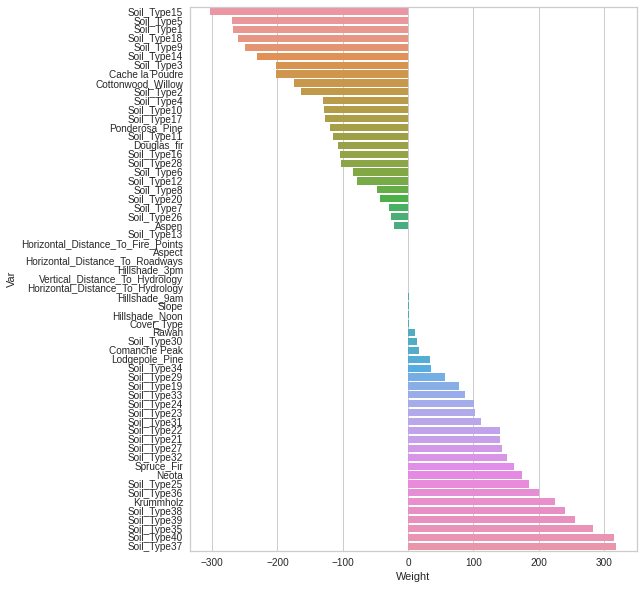

In [ ]:
Weights = pd.Series(lin_reg.coef_[0], index = Xreg.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
plt.figure(figsize=(8, 10))
sns.barplot(x='Weight', y = 'Var', data = Weights);

In [ ]:
#Simplifying the model before running again
i=1
Xreg_small=Xreg.drop(['Aspect', 
                      'Horizontal_Distance_To_Roadways', 
                      'Vertical_Distance_To_Hydrology', 
                      'Horizontal_Distance_To_Hydrology', 
                      'Hillshade_3pm',
                      'Hillshade_Noon',
                      'Slope',
                      'Hillshade_9am',
                      'Soil_Type34'], axis=1)
for train_idx_reg, test_idx_reg in cv.split(Xreg_small, yreg):

    X_train_reg, X_test_reg = Xreg_small.iloc[train_idx_reg], Xreg_small.iloc[test_idx_reg]
    y_train_reg, y_test_reg = Xreg_small.iloc[train_idx_reg], Xreg_small.iloc[test_idx_reg]

    # Train the model
    lin_reg.fit(X_train_reg, y_train_reg)

    # Predict 
    y_pred_lin_reg = lin_reg.predict(X_test_reg)


    # Calculate the mean absolute error, mean squared error, and root mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(y_test_reg, y_pred_lin_reg)
    lin_MSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_lin_reg)
    lin_RMSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_lin_reg)
    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)
    MSE.append(lin_MSE_reg)
    RMSE.append(lin_RMSE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, lin_MSE_reg, lin_RMSE_reg]], 
               headers=['Fold', 'MAE', 'RMSE']))

           Fold          MAE         RMSE
--  -----------  -----------  -----------
 2  1.60217e-14  9.48422e-27  9.48422e-27
           Fold          MAE         RMSE
--  -----------  -----------  -----------
 3  9.54911e-15  3.57529e-27  3.57529e-27
           Fold          MAE         RMSE
--  -----------  -----------  -----------
 4  1.80016e-14  1.59748e-26  1.59748e-26
           Fold          MAE         RMSE
--  -----------  -----------  -----------
 5  5.13091e-14  1.89302e-25  1.89302e-25
           Fold          MAE         RMSE
--  -----------  -----------  -----------
 6  1.77501e-14  1.34985e-26  1.34985e-26
           Fold          MAE         RMSE
--  -----------  -----------  -----------
 7  4.17133e-14  1.07958e-25  1.07958e-25
           Fold          MAE         RMSE
--  -----------  -----------  -----------
 8  2.24031e-14  2.72846e-26  2.72846e-26
           Fold          MAE         RMSE
--  -----------  -----------  -----------
 9  1.71257e-14  1.20969e-26  1.20

In [ ]:
# Print the mean scores
print('\n')
print('Mean MAE:', sum(MAE) / len(MAE))
print('Mean RMSE:', sum(RMSE) / len(RMSE))



Mean MAE: 45.765152628832695
Mean RMSE: 6713.3369339702385


In [ ]:
#moved back to smaller dataframe due to excessive times for using grid search on the expanded dataframe
# Make target variable and data variable
yreg = forest_cover_type[['Elevation']]
Xreg = forest_cover_type.loc[:, forest_cover_type.columns != 'Elevation']

#Exceptional work grid search for tuning knn
#Note, this was taking over 60 minutes to run. 
#Since gridsearch kept selecting the highest # of neighbors, have updated to a smaller list of larger k values
params = {'n_neighbors':[20, 40, 50]}

knn_reg = neighbors.KNeighborsRegressor()
GridSearch = GridSearchCV(knn_reg, params, cv=10)
GridSearch.fit(X_train_reg,y_train_reg)
GridSearch.best_params_


In [ ]:
#putting Grid Search results in a dataframe for reference in the Exceptional Work section
GridSearch_Results=pd.DataFrame(GridSearch.cv_results_)

In [ ]:
# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []
MSE = []
RMSE = []

knn_reg = neighbors.KNeighborsRegressor(45)

for train_idx_reg, test_idx_reg in cv.split(Xreg, yreg):

    X_train_reg, X_test_reg = Xreg.iloc[train_idx_reg], Xreg.iloc[test_idx_reg]
    y_train_reg, y_test_reg = yreg.iloc[train_idx_reg], yreg.iloc[test_idx_reg]

    # Train the model
    knn_reg.fit(X_train_reg, y_train_reg)

    # Predict 
    y_pred_knn_reg = knn_reg.predict(X_test_reg)


    # Calculate the mean absolute error, mean squared error, and root mean squared error
    knn_MAE_reg= metrics.mean_absolute_error(y_test_reg, y_pred_knn_reg)
    knn_MSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_knn_reg)
    knn_RMSE_reg= metrics.mean_squared_error(y_test_reg, y_pred_knn_reg)

    # Append to the list
    MAE.append(knn_MAE_reg)
    MSE.append(knn_MSE_reg)
    RMSE.append(knn_RMSE_reg)

    # Print the scores
    print('MAE:', knn_MAE_reg)
    print('MSE:', knn_MSE_reg)
    print('RMSE:', knn_RMSE_reg)
    print('\n')


MAE: 101.04324196145477
MSE: 21545.25704209413
RMSE: 21545.25704209413


MAE: 101.65792724671935
MSE: 21817.977500700134
RMSE: 21817.977500700134


MAE: 100.85673224213008
MSE: 21374.288466941667
RMSE: 21374.288466941667


MAE: 102.07011812762835
MSE: 21918.971357242743
RMSE: 21918.971357242743


MAE: 101.14453757728398
MSE: 21568.0453779317
RMSE: 21568.0453779317


MAE: 101.35032214018118
MSE: 21731.675100825916
RMSE: 21731.675100825916


MAE: 101.38974850308563
MSE: 21591.877386305372
RMSE: 21591.877386305372


MAE: 101.41773960670024
MSE: 21635.37803808226
RMSE: 21635.37803808226


MAE: 101.15241160507851
MSE: 21741.081359123247
RMSE: 21741.081359123247


MAE: 101.52202046627617
MSE: 21847.46441673195
RMSE: 21847.46441673195




---
# Modeling and Evaluation 4

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.


In [ ]:
print('The summary of the 3 tested models for forest cover type:')
print('\n')

print(tabulate([['Random Forest', rfc_accuracy, rfc_precision, rfc_recall, rfc_f1], 
                ['Logistic Regression', lr_accuracy, log_precision, log_recall, log_f1], 
                ['KNN', knn_accuracy, knn_precision, knn_recall, knn_f1]], 
               headers=['Model', 'Accuracy', 'Precision', 'Recall', 'F1']))

The summary of the 3 tested models for forest cover type:


Model                  Accuracy    Precision    Recall        F1
-------------------  ----------  -----------  --------  --------
Random Forest          0.965026     0.965083  0.965026  0.964895
Logistic Regression    0.623934     0.575734  0.623934  0.588146
KNN                    0.965758     0.96592   0.965758  0.965623


Overall, when comparing the three models to predict the forest cover type, the KNN model is slightly better than the Random Forest model in accuracy, precision, and recall. 



In [ ]:
## This code block is temporary (printing for summary table below)
print(tabulate([['Random Forest Regression', rf_MAE_reg, rf_RMSE_reg], 
                ['Linear Regression', lin_MAE_reg, lin_RMSE_reg], 
                ['KNN Regression', knn_MAE_reg, knn_RMSE_reg]], 
               headers=['Model', 'MAE', 'RMSE']))


Model                         MAE     RMSE
------------------------  -------  -------
Random Forest Regression  104.344  18032.7
Linear Regression         197.305  59284.4
KNN Regression            101.522  21847.5


Comparing the models to predict elevation, Random Forest had the lowest RMSE. This may be due to some of the irregular patterns seen in Horizontal Distance to Fire points, which random forest would be especially adept at capturing.

<AxesSubplot:xlabel='Horizontal_Distance_To_Fire_Points', ylabel='Elevation'>

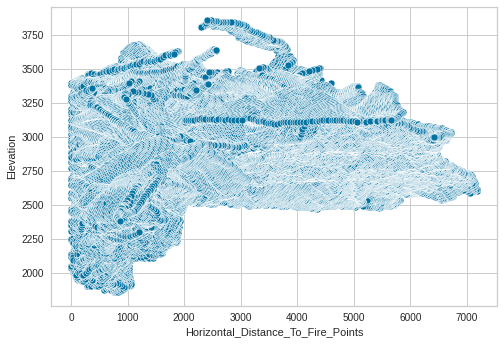

In [ ]:
sns.scatterplot(x = 'Horizontal_Distance_To_Fire_Points', y = 'Elevation', data = forest_cover_type)


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=knn,estimator2=rfc,X=X, y=y)
alpha = 0.05

print('t statistic: %.3f' % t)
print('aplha ', alpha)
print('p value: %.3f' % p)

if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

--- 
# Modeling and Evaluation 5

Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. 

Random forest and knn have an advantage for capturing some of the nuance in the relationship between elevation and cover type with variables like horizontal distance to fire point.

Is any model better than another? KNN did slightly better for Cover Type, Random Forest regression did best for predicting elevation.

Is the difference significant with 95% confidence? 

Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.


**Accuracy Scores for various splitting methods vs models**

Splitting Method   | Random Forest | KNN    | Logistic
-------------------|---------------|--------|---------
Test/Train         | 0.9625        | 0.9658 | 0.6242
Cross Validation   | 0.9656        | 0.5362 | 0.6009
Stratified CV      | 0.9655        | 0.5362 | 0.6009




We looked at Train/Test Split to begin wih because it the most simplified and well-known form of data separation. We saw accuracy scores around 96% for Random Forest and kNN, but for Logistic Regression it dipped down to 62%. However, we have cause for concern with this method of splitting the data due to two of the Cover Types being highly skewed. Because of this, we looked at other data separation techniques. 

We use Stratified 10 Fold Cross Validation to help with the imbalanced dataset. This implements a fold in the data where each fold has the same ratio of instances of target variable as in the whole dataset. However, we saw a huge time increase in running this model. So something we have to consider is if the additional time is worth it? 

For our specific dataset, we saw about the same accuracy score. We had to look at some other performance metrics to gain a better understanding if the additional time is worth it. 

---
# Modeling and Evaluation 6

#### Important features for classifying cover type




We looked at the feature importances from the random forest and logisitic regression models to investigate which attributes were the most important in classifying the cover type of a land plot

<BarContainer object of 12 artists>

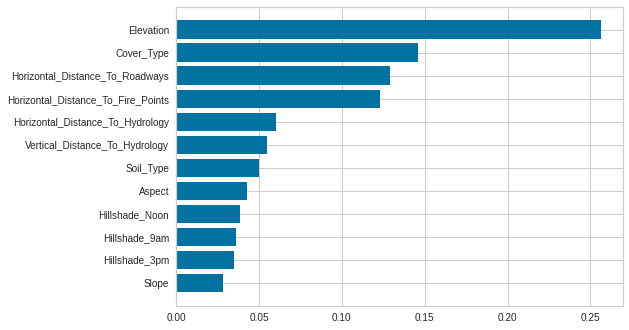

In [ ]:
# Random Forest
rfFeatures = rfc.feature_importances_.argsort()
plt.barh(forest_cover_type.columns.values[rfFeatures],rfc.feature_importances_[rfFeatures])

<AxesSubplot:xlabel='Weight', ylabel='Var'>

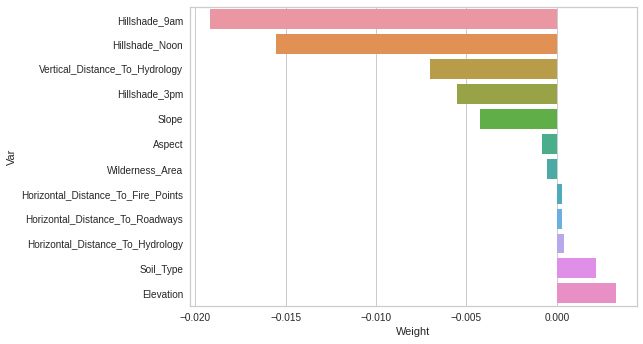

In [ ]:
# Logistic Regression
lrWeights = pd.Series(lr.coef_[0],index=X.columns)
lrWeights = pd.DataFrame({'Var':lrWeights.index,'Weight':lrWeights.values})
lrWeights = lrWeights.sort_values('Weight')
sns.barplot(x='Weight',y='Var',data=lrWeights)

For the random forest classifier the most important attributes were elevation and horizontal distance to roadways and fire points. Distance to hydrology, soil type, aspect and hillshade were also somewhat important to the performance of the model.

For the logistic regression model hillshade and vertical distance to hydrology were the most important with slope, elevation, and soil type also being somewhat important. 

The most common attributes between the two models were elevation, distance to water, soil type, and hillshade or the amount of sun a plot of land receives throughout the day. These were likely important as all of these factors impact what types of trees grow and thrive in these conditions. Certain trees will favor different amounts of water and sunlight and may outperform other trees at higher elevations or in different types of soil.

#### Important features for predicting elevation

For performing regression on predictng elevation we investigated the attribute importance from the random forest and linear regression models.

<BarContainer object of 12 artists>

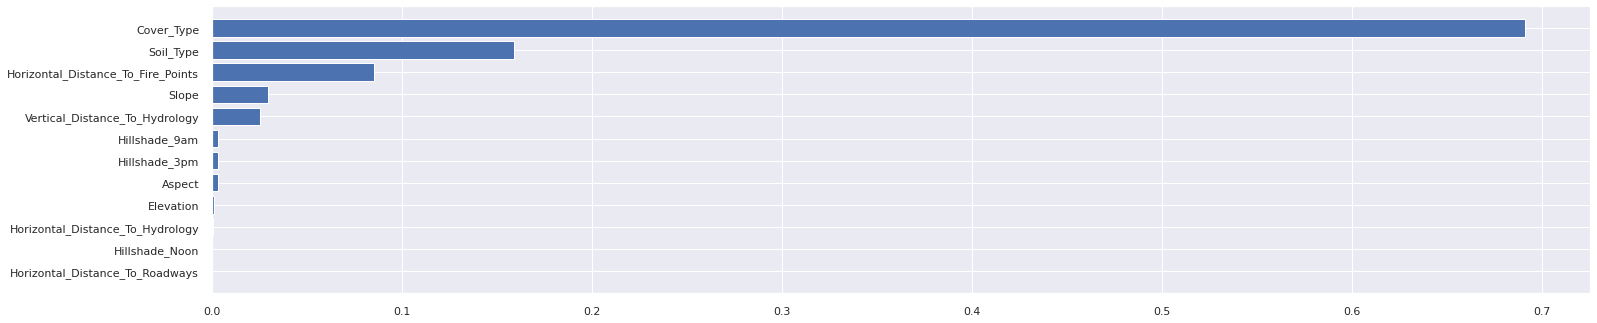

In [ ]:
# Random Forest
rfRegFeatures = rf_reg.feature_importances_.argsort()
plt.barh(forest_cover_type.columns.values[rfRegFeatures],rf_reg.feature_importances_[rfRegFeatures])


<AxesSubplot:xlabel='Coefficients', ylabel='Features'>

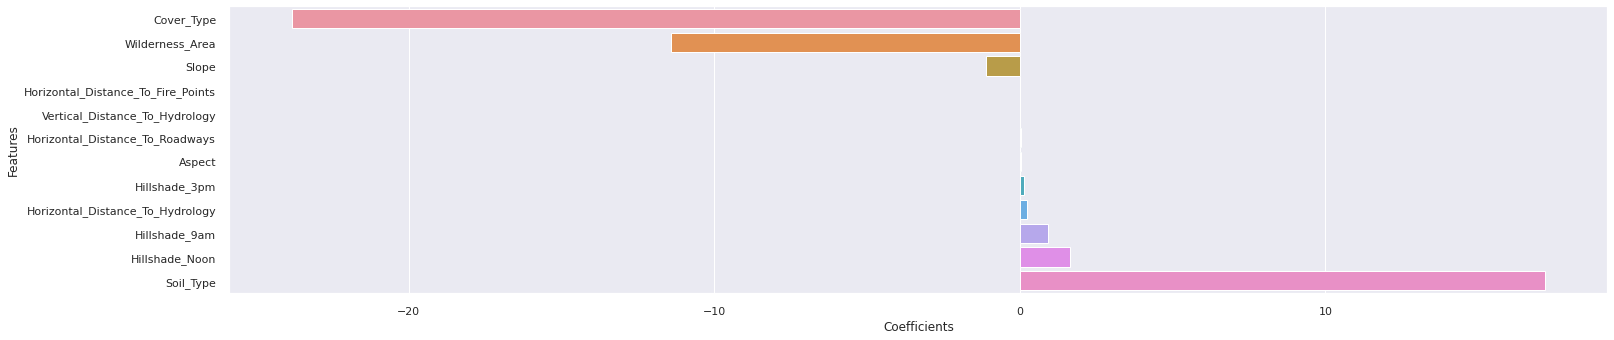

In [ ]:
# Linear Regression
regFeatures = pd.DataFrame(Xreg.columns,columns=['Features'])
regCoef = pd.DataFrame(np.transpose(lin_reg.coef_),columns=['Coefficients'])
linRegCoef = pd.concat([regFeatures,regCoef],axis=1).sort_values('Coefficients')
sns.barplot(x='Coefficients',y='Features',data=linRegCoef)


For the random forest classifier, the most important attributes were cover type, soil type, distance to fire points and water, and slope.

For the linear regression model, the features that impacted the model the most were cover type, soil type, wilderness area, slope, and hillshade.

The common important features between the two models were cover type, soil type, and slope. This was likely due to a number of factors. As we saw in the models that classified cover type elevation was important and it's not surpising that the reverse is also true. If different cover types thrive at certain elevations, that can be used to estimate elevation based on what type of cover you see at that plot of land. This is likely the case with soil type as well, with different combinations of soil and rock occuring at different altitudes. For slope, specific mountain and hill ranges will change slope based on elevation, commonly getting steeper near the peaks. This is likely why slope was an important predictor for elevation.

---
# Deployment


The model we created could be used by various environmental agencies, logging companies, real estate companies, and government agencies to use readily available data to predict what types of trees or forest cover are in a plot of land without having to perform a expensive survey. This could impact analysis on the effects of deforestation, wildfires, and climate change, be used to choose appropriate places for logging or development, or track how protection policies are working. The model’s value could be measured by how likely it is to choose the correct class of cover type and at what resolution of plot size it could still perform well. The performance could also be evaluated by testing the model on similar data from a region near the Roosevelt National Forest but outside the range of the original data to test if performance is still adequate. The model could be deployed as a web based application that incorporates the GIS and land survey data used to train it to predict cover type of a user selected plot of land. However, with the current data used to train the model, only areas in Northern Colorado with similar geography and cover types could benefit from this model. Additional data could be collected to include more diverse landscapes with different cover types. Any additional data would require the model to be retrained to ensure the desired performance is met on different types of land and cover types. Data would need to be updated whenever new land areas are included, development or a natural disaster occurs, or yearly if no notable changes occur.

---
# Exceptional Work

We decided to leverage GridSearchCV for knn, to find the best k value (number of nearest neighbors).


### Testing out a pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Define the classifiers
svm = SVC(kernel='linear', C=1)
logistic = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', 'passthrough')
])

# Set up the hyperparameters to be tuned for each model
svm_params = {'classifier': [svm]}
logistic_params = {'classifier': [logistic]}
rfc_params = {'classifier': [rfc]}

# Add the parameter dictionaries to a list
params = [svm_params, logistic_params, rfc_params]


# Train the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict the classes of the testing data using the pipeline
y_pred = pipe.predict(X_test)

# Calculate the accuracy of the pipeline
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

When the classes are imbalanced, the area under the Receiver Operating Characteristic (ROC) curve (AUC) is a useful evaluation metric. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various thresholds. The AUC represents the probability that a randomly selected positive example will be ranked higher than a randomly selected negative example.